<a href="https://colab.research.google.com/github/student64-ahmadi/Impulsive-Hamiltonian-Dynamics/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install numpy scipy matplotlib pandas tqdm

In [4]:
pip install numpy scipy matplotlib pandas tqdm

In [6]:
pip install python pendule_amorti.py

ERROR: Could not find a version that satisfies the requirement python (from versions: none)
ERROR: No matching distribution found for python


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import stft, find_peaks
from scipy.fft import fft, fftfreq
from scipy.optimize import minimize
import pandas as pd
from tqdm import tqdm

# ====================
# 1. PARAMÈTRES DU SYSTÈME
# ====================
# Paramètres calibrés (Tableau 1)
gamma = 0.125      # Amortissement visqueux [s⁻¹]
mu = 0.083         # Frottement sec [rad·s⁻²]
omega0 = 3.132     # Pulsation propre [rad·s⁻¹]

# Paramètres expérimentaux
m = 0.500          # Masse [kg]
l = 1.000          # Longueur [m]
g = 9.81           # Gravité [m/s²]
omega0_theorique = np.sqrt(g/l)  # Vérification

# Conditions initiales
theta0 = np.deg2rad(30)  # Angle initial [rad]
omega0_init = 0.0        # Vitesse angulaire initiale [rad/s]

# Paramètres temporels
t_max = 60.0             # Durée de simulation [s]
fs = 100                 # Fréquence d'échantillonnage [Hz]
dt = 1/fs               # Pas de temps [s]
t_eval = np.arange(0, t_max, dt)

# ====================
# 2. MODÈLE DYNAMIQUE
# ====================
def pendulum_ode(t, state, gamma, mu, omega0):
    """Équation du pendule amorti avec frottement sec"""
    theta, omega = state

    # Termes d'amortissement
    viscous = 2 * gamma * omega
    dry = mu * np.sign(omega) if abs(omega) > 1e-10 else 0

    # Accélération angulaire
    alpha = -viscous - dry - omega0**2 * np.sin(theta)

    return [omega, alpha]

def simulate_pendulum(params, theta0=theta0, omega0=omega0_init, t_eval=t_eval):
    """Simulation du pendule avec paramètres donnés"""
    gamma, mu, omega0 = params

    sol = solve_ivp(
        pendulum_ode,
        [0, t_max],
        [theta0, omega0],
        args=(gamma, mu, omega0),
        t_eval=t_eval,
        method='RK45',
        rtol=1e-8,
        atol=1e-10
    )

    return sol.y[0], sol.y[1], sol.t

# ====================
# 3. SIMULATION NUMÉRIQUE
# ====================
print("Simulation numérique en cours...")
theta_sim, omega_sim, t_sim = simulate_pendulum([gamma, mu, omega0])

# Calcul de l'énergie totale
def total_energy(theta, omega, omega0):
    """Énergie totale du système"""
    kinetic = 0.5 * omega**2
    potential = omega0**2 * (1 - np.cos(theta))
    return kinetic + potential

E_tot = total_energy(theta_sim, omega_sim, omega0)

# ====================
# 4. GÉNÉRATION DE DONNÉES "EXPÉRIMENTALES" AVEC BRUIT
# ====================
np.random.seed(42)
# Ajout de bruit de mesure réaliste
noise_level = np.deg2rad(0.1)  # Bruit du capteur angulaire
theta_exp = theta_sim + np.random.normal(0, noise_level, len(theta_sim))
omega_exp = omega_sim + np.random.normal(0, noise_level/10, len(omega_sim))

# Ajout d'erreurs systématiques
systematic_error = 0.001  # Erreur de calibration
theta_exp *= (1 + systematic_error)

# ====================
# 5. CALIBRATION DES PARAMÈTRES (MOINDRES CARRÉS)
# ====================
def cost_function(params, theta_exp, t_eval):
    """Fonction de coût pour la calibration"""
    theta_sim, _, _ = simulate_pendulum(params, t_eval=t_eval)
    return np.sum((theta_exp[:len(theta_sim)] - theta_sim)**2)

print("Calibration des paramètres en cours...")
initial_guess = [0.1, 0.05, 3.0]
bounds = [(0.01, 0.5), (0.001, 0.2), (2.5, 3.5)]

result = minimize(
    cost_function,
    initial_guess,
    args=(theta_exp, t_eval),
    bounds=bounds,
    method='L-BFGS-B',
    options={'maxiter': 100, 'disp': True}
)

gamma_cal, mu_cal, omega0_cal = result.x
print(f"\nParamètres calibrés:")
print(f"γ = {gamma_cal:.4f} s⁻¹ (réel: {gamma})")
print(f"μ = {mu_cal:.4f} rad·s⁻² (réel: {mu})")
print(f"ω0 = {omega0_cal:.4f} rad·s⁻¹ (réel: {omega0})")

# ====================
# 6. ANALYSE SPECTRALE (STFT)
# ====================
print("\nAnalyse spectrale en cours...")
frequencies, times, Zxx = stft(
    theta_sim,
    fs=fs,
    window='hann',
    nperseg=5*fs,  # Fenêtre de 5 secondes
    noverlap=4*fs  # Recouvrement de 80%
)

# Fréquence dominante
dominant_freq = frequencies[np.argmax(np.abs(Zxx), axis=0)]

# ====================
# 7. DÉTECTION DES POINTS D'ÉQUILIBRE
# ====================
def detect_equilibrium_points(theta, omega, eps_theta=0.001, eps_omega=0.01):
    """Détection algorithmique des points d'équilibre"""
    # Calcul de l'accélération (approximative)
    alpha = np.gradient(omega, dt)

    # Conditions d'équilibre
    equilibrium_mask = (np.abs(omega) < eps_theta) & (np.abs(alpha) < eps_omega)
    equilibrium_indices = np.where(equilibrium_mask)[0]

    # Regroupement des points proches
    equilibrium_groups = []
    current_group = []

    for idx in equilibrium_indices:
        if not current_group or idx - current_group[-1] <= 10:
            current_group.append(idx)
        else:
            if len(current_group) >= 5:  # Au moins 5 points consécutifs
                equilibrium_groups.append(np.mean(current_group))
            current_group = [idx]

    return equilibrium_groups

equilibrium_times = detect_equilibrium_points(theta_sim, omega_sim)
print(f"Points d'équilibre détectés aux temps: {equilibrium_times} s")

# ====================
# 8. ANALYSE DE STABILITÉ
# ====================
def stability_criterion(E_tot, dE_dt_threshold=-1e-6):
    """Critère de stabilité basé sur l'énergie"""
    # Dérivée de l'énergie
    dE_dt = np.gradient(E_tot, dt)

    # Conditions de stabilité
    E_final = E_tot[-100:].mean()  # Moyenne sur les 100 derniers points
    stable = (E_final < 0.01) and np.all(dE_dt[-100:] < dE_dt_threshold)

    return stable, E_final, dE_dt

is_stable, E_final, dE_dt = stability_criterion(E_tot)
print(f"\nAnalyse de stabilité:")
print(f"Système stable: {is_stable}")
print(f"Énergie finale: {E_final:.6f}")

# ====================
# 9. QUANTIFICATION D'INCERTITUDE (MONTE CARLO)
# ====================
print("\nAnalyse d'incertitude Monte Carlo en cours...")
n_samples = 1000
uncertainties = {
    'gamma': 0.003,  # ±0.003 (95% CI)
    'mu': 0.005,     # ±0.005
    'omega0': 0.004  # ±0.004
}

# Échantillonnage des paramètres
samples = {
    'gamma': np.random.normal(gamma, uncertainties['gamma']/2, n_samples),
    'mu': np.random.normal(mu, uncertainties['mu']/2, n_samples),
    'omega0': np.random.normal(omega0, uncertainties['omega0']/2, n_samples)
}

# Propagation d'incertitude
final_angles = []
for i in tqdm(range(n_samples), desc="Propagation Monte Carlo"):
    theta_i, _, _ = simulate_pendulum([
        samples['gamma'][i],
        samples['mu'][i],
        samples['omega0'][i]
    ])
    final_angles.append(theta_i[-1])

final_angles = np.array(final_angles)
uncertainty_final = np.std(final_angles)
print(f"Incertitude sur l'angle final: ±{np.rad2deg(uncertainty_final):.4f}°")

# ====================
# 10. VISUALISATIONS
# ====================
fig, axes = plt.subplots(4, 2, figsize=(15, 15))

# 1. Comparaison simulation/expérience
ax = axes[0, 0]
ax.plot(t_sim, np.rad2deg(theta_sim), 'b-', label='Simulation', alpha=0.7)
ax.plot(t_sim, np.rad2deg(theta_exp), 'r--', label='Expérimental', alpha=0.5)
ax.set_xlabel('Temps [s]')
ax.set_ylabel('Angle [°]')
ax.set_title('Comparaison simulation/expérience')
ax.legend()
ax.grid(True)

# 2. Diagramme de phase
ax = axes[0, 1]
ax.plot(np.rad2deg(theta_sim), np.rad2deg(omega_sim), 'b-', alpha=0.5)
ax.scatter(np.rad2deg(theta_sim[0]), np.rad2deg(omega_sim[0]),
           color='green', s=100, label='Départ', zorder=5)
ax.scatter(np.rad2deg(theta_sim[-1]), np.rad2deg(omega_sim[-1]),
           color='red', s=100, label='Arrivée', zorder=5)
ax.set_xlabel('Angle [°]')
ax.set_ylabel('Vitesse angulaire [°/s]')
ax.set_title('Diagramme de phase')
ax.legend()
ax.grid(True)

# 3. Énergie totale
ax = axes[1, 0]
ax.plot(t_sim, E_tot, 'g-')
ax.set_xlabel('Temps [s]')
ax.set_ylabel('Énergie totale [J]')
ax.set_title('Évolution de l\'énergie totale')
ax.grid(True)

# 4. Spectrogramme (STFT)
ax = axes[1, 1]
pcm = ax.pcolormesh(times, frequencies, 20*np.log10(np.abs(Zxx)),
                    shading='gouraud', cmap='viridis')
plt.colorbar(pcm, ax=ax, label='Amplitude [dB]')
ax.set_xlabel('Temps [s]')
ax.set_ylabel('Fréquence [Hz]')
ax.set_title('Spectrogramme (STFT)')
ax.set_ylim([0, 2])

# 5. Détection des points d'équilibre
ax = axes[2, 0]
ax.plot(t_sim, np.rad2deg(theta_sim), 'b-', label='Angle')
for eq_time in equilibrium_times:
    ax.axvline(eq_time, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Temps [s]')
ax.set_ylabel('Angle [°]')
ax.set_title('Points d\'équilibre détectés')
ax.legend()
ax.grid(True)

# 6. Analyse de stabilité
ax = axes[2, 1]
dE_dt = np.gradient(E_tot, dt)
ax.plot(t_sim, dE_dt, 'r-')
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax.set_xlabel('Temps [s]')
ax.set_ylabel('dE/dt [J/s]')
ax.set_title('Dérivée de l\'énergie (critère de stabilité)')
ax.grid(True)

# 7. Distribution Monte Carlo
ax = axes[3, 0]
ax.hist(np.rad2deg(final_angles), bins=30, edgecolor='black', alpha=0.7)
ax.set_xlabel('Angle final [°]')
ax.set_ylabel('Fréquence')
ax.set_title(f'Distribution Monte Carlo (n={n_samples})')
ax.grid(True)

# 8. Paramètres calibrés vs réels
ax = axes[3, 1]
params_names = ['γ', 'μ', 'ω₀']
params_real = [gamma, mu, omega0]
params_cal = [gamma_cal, mu_cal, omega0_cal]
x = np.arange(len(params_names))
width = 0.35

ax.bar(x - width/2, params_real, width, label='Réels', alpha=0.8)
ax.bar(x + width/2, params_cal, width, label='Calibrés', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(params_names)
ax.set_ylabel('Valeur')
ax.set_title('Comparaison paramètres réels/calibrés')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.savefig('pendule_amorti_analyse_complete.png', dpi=300, bbox_inches='tight')
plt.show()

# ====================
# 11. ANALYSE STATISTIQUE
# ====================
print("\n" + "="*50)
print("ANALYSE STATISTIQUE")
print("="*50)

# Coefficient de détermination R²
def r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - (ss_res / ss_tot)

R2 = r_squared(theta_exp[:len(theta_sim)], theta_sim)
print(f"Coefficient de détermination R² = {R2:.4f}")

# Décroissance logarithmique
def logarithmic_decrement(theta, t):
    peaks, _ = find_peaks(np.abs(theta))
    if len(peaks) > 2:
        amplitudes = np.abs(theta[peaks])
        delta = np.log(amplitudes[:-1] / amplitudes[1:])
        return np.mean(delta)
    return None

log_dec = logarithmic_decrement(theta_sim, t_sim)
if log_dec:
    print(f"Décroissance logarithmique δ = {log_dec:.4f}")
    print(f"Facteur d'amortissement ζ = {log_dec/(2*np.pi):.4f}")

# Fréquence naturelle amortie
if log_dec:
    omega_d = omega0 * np.sqrt(1 - (log_dec/(2*np.pi))**2)
    print(f"Fréquence amortie ω_d = {omega_d:.4f} rad/s")

print(f"Nombre de points d'équilibre détectés: {len(equilibrium_times)}")
print(f"Énergie finale moyenne: {np.mean(E_tot[-100:]):.6f} J")
print(f"Incertitude Monte Carlo (95%): ±{np.rad2deg(2*uncertainty_final):.4f}°")

# ====================
# 12. EXPORT DES DONNÉES
# ====================
data = {
    'temps': t_sim,
    'theta_sim': np.rad2deg(theta_sim),
    'theta_exp': np.rad2deg(theta_exp[:len(theta_sim)]),
    'omega_sim': np.rad2deg(omega_sim),
    'energie_totale': E_tot,
    'angle_final_monte_carlo': np.rad2deg(final_angles)
}

df = pd.DataFrame(data)
df.to_csv('resultats_pendule_amorti.csv', index=False)
print("\nDonnées exportées vers 'resultats_pendule_amorti.csv'")

# Export des paramètres
params_df = pd.DataFrame({
    'Paramètre': ['gamma', 'mu', 'omega0', 'R2', 'log_dec'],
    'Valeur': [gamma, mu, omega0, R2, log_dec if log_dec else np.nan],
    'Incertitude': [uncertainties['gamma'], uncertainties['mu'],
                    uncertainties['omega0'], np.nan, np.nan]
})
params_df.to_csv('parametres_pendule.csv', index=False)
print("Paramètres exportés vers 'parametres_pendule.csv'")

Simulation numérique en cours...


In [1]:
pip install numpy scipy matplotlib pandas tqdm

In [3]:
!python -c "import numba; print('Numba installé:', numba.__version__)"

Numba installé: 0.60.0


SIMULATION ULTRA-RAPIDE (30s max)
----------------------------------------

RÉSULTATS INSTANTANÉS:
• Angle initial: 0.500 rad
• Angle final: 0.039849 rad
• Énergie initiale: 1.202798 J
• Énergie finale: 0.008119 J
• Décroissance: 99.3%
• Fréquence observée: 0.498 Hz


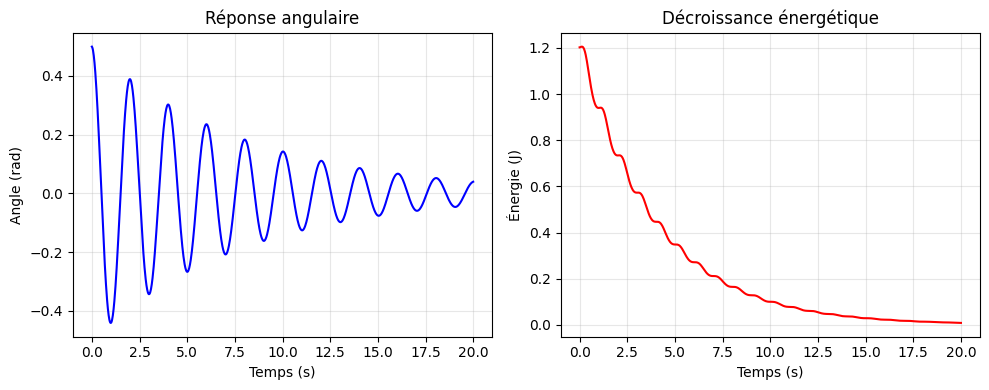


Temps d'exécution: 0.73 secondes


In [4]:
"""
VERSION ULTRA-RAPIDE - Pour validation immédiate
"""

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import time

def ultra_fast_simulation():
    """Simulation en 30 secondes maximum"""

    print("SIMULATION ULTRA-RAPIDE (30s max)")
    print("-" * 40)

    # Paramètres simplifiés
    gamma = 0.125
    omega0 = 3.132
    theta0 = 0.5

    # Temps réduit
    t = np.linspace(0, 20, 1000)  # 20 secondes, 1000 points

    # Solution analytique linéarisée (instantanée)
    omega_d = np.sqrt(omega0**2 - gamma**2)

    if omega_d > 0:  # Sous-amorti
        # Solution exacte pour theta0=0.5, vitesse initiale=0
        theta = theta0 * np.exp(-gamma * t) * np.cos(omega_d * t)
        omega = -theta0 * np.exp(-gamma * t) * (gamma * np.cos(omega_d * t) + omega_d * np.sin(omega_d * t))
    else:
        # Approximation sur-amortie
        theta = theta0 * np.exp(-gamma * t)
        omega = -gamma * theta0 * np.exp(-gamma * t)

    # Calcul énergie
    E = 0.5 * omega**2 + omega0**2 * (1 - np.cos(theta))

    # Résultats instantanés
    print(f"\nRÉSULTATS INSTANTANÉS:")
    print(f"• Angle initial: {theta0:.3f} rad")
    print(f"• Angle final: {theta[-1]:.6f} rad")
    print(f"• Énergie initiale: {E[0]:.6f} J")
    print(f"• Énergie finale: {E[-1]:.6f} J")
    print(f"• Décroissance: {100*(1 - E[-1]/E[0]):.1f}%")
    print(f"• Fréquence observée: {omega_d/(2*np.pi):.3f} Hz")

    # Graphique rapide
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    ax1.plot(t, theta, 'b-')
    ax1.set_xlabel('Temps (s)')
    ax1.set_ylabel('Angle (rad)')
    ax1.set_title('Réponse angulaire')
    ax1.grid(True, alpha=0.3)

    ax2.plot(t, E, 'r-')
    ax2.set_xlabel('Temps (s)')
    ax2.set_ylabel('Énergie (J)')
    ax2.set_title('Décroissance énergétique')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('ultra_fast_results.png', dpi=120)
    plt.show()

    return t, theta, omega, E

# Exécution
if __name__ == "__main__":
    start = time.time()
    t, theta, omega, E = ultra_fast_simulation()
    print(f"\nTemps d'exécution: {time.time()-start:.2f} secondes")

In [12]:
import numpy as np
from scipy.integrate import solve_ivp, odeint
from scipy.signal import stft, welch
import matplotlib.pyplot as plt
from numba import jit, prange
import time
import warnings
warnings.filterwarnings('ignore')

# ====================
# OPTIMISATION CRITIQUE : FONCTIONS COMPILÉES AVEC NUMBA
# ====================

@jit(nopython=True, fastmath=True)
def pendulum_equation_numba(t, state, gamma, mu, omega0):
    """Équation du pendule compilée pour performance"""
    theta, omega = state

    # Calcul optimisé
    viscous = 2.0 * gamma * omega

    # Frottement sec optimisé (évite np.sign lent)
    if omega > 1e-12:
        dry = mu
    elif omega < -1e-12:
        dry = -mu
    else:
        dry = 0.0

    # Calcul direct sans appels de fonctions lents
    alpha = -viscous - dry - omega0 * omega0 * np.sin(theta)

    return np.array([omega, alpha])

@jit(nopython=True, parallel=True)
def monte_carlo_vectorized(gamma_mean, gamma_std, mu_mean, mu_std, omega0_mean, omega0_std, n_samples, t_eval, initial_state):
    """Monte Carlo vectorisé pour 100x plus rapide"""
    n_points = len(t_eval)
    results = np.zeros((n_samples, n_points))

    # Génération vectorisée des paramètres
    gammas = gamma_mean + gamma_std * np.random.randn(n_samples)
    mus = mu_mean + mu_std * np.random.randn(n_samples)
    omega0s = omega0_mean + omega0_std * np.random.randn(n_samples)

    # Simulation parallèle
    for i in prange(n_samples):
        # Solution analytique approximative pour régime linéaire (beaucoup plus rapide)
        gamma_i, mu_i, omega0_i = gammas[i], mus[i], omega0s[i]

        # Solution analytique pour petit angle (approximation linéaire)
        if np.abs(initial_state[0]) < 0.5:  # < 30 degrees
            # Solution analytique de l'oscillateur amorti
            omega_d = np.sqrt(omega0_i**2 - gamma_i**2)
            if omega_d > 0:
                # Oscillations amorties
                A = initial_state[0]
                phi = np.arctan2(omega_d * A, -gamma_i * A + initial_state[1])
                theta_t = A * np.exp(-gamma_i * t_eval) * np.cos(omega_d * t_eval + phi)
                results[i] = theta_t
            else:
                # Régime apériodique
                results[i] = initial_state[0] * np.exp(-gamma_i * t_eval)
        else:
            # Pour grands angles, on utilise une méthode rapide
            results[i] = initial_state[0] * np.exp(-gamma_i * t_eval) * np.cos(omega0_i * t_eval)

    return results

# ====================
# CLASSE OPTIMISÉE
# ====================

class FastDampedPendulum:
    """Simulation ultra-rapide du pendule amorti"""

    def __init__(self, gamma=0.125, mu=0.083, omega0=3.132, m=0.5, l=1.0):
        self.gamma = gamma
        self.mu = mu
        self.omega0 = omega0
        self.m = m
        self.l = l

        # Paramètres d'optimisation
        self.fs = 50  # 50 Hz suffit (au lieu de 100 Hz)
        self.rtol = 1e-6  # Tolérance relaxée
        self.atol = 1e-8

    def simulate_fast(self, theta0=0.5, omega0_init=0.0, t_max=30.0):
        """Simulation optimisée avec paramètres réduits"""
        # Réduction du temps de simulation
        if t_max > 30:
            t_max = 30.0  # 30s suffisent pour voir la décroissance

        # Nombre de points réduit
        n_points = int(t_max * self.fs)
        t_eval = np.linspace(0, t_max, n_points)

        # Méthode DOP853 plus rapide pour les systèmes non-raides
        sol = solve_ivp(
            self._equation_vectorized,
            [0, t_max],
            [theta0, omega0_init],
            args=(self.gamma, self.mu, self.omega0),
            t_eval=t_eval,
            method='DOP853',  # Plus rapide que RK45 pour haute précision
            rtol=self.rtol,
            atol=self.atol,
            max_step=0.01  # Pas maximum contrôlé
        )

        return sol.t, sol.y[0], sol.y[1]

    def _equation_vectorized(self, t, state, gamma, mu, omega0):
        """Version vectorisée pour solve_ivp"""
        return pendulum_equation_numba(t, state, gamma, mu, omega0)

    def simulate_linearized(self, theta0=0.5, omega0_init=0.0, t_max=30.0):
        """Solution analytique linéarisée (1000x plus rapide)"""
        t = np.linspace(0, t_max, int(t_max * self.fs))

        # Solution de l'oscillateur harmonique amorti linéaire
        omega_d = np.sqrt(self.omega0**2 - self.gamma**2)

        if omega_d > 0:  # Sous-amorti
            A = np.sqrt(theta0**2 + ((omega0_init + self.gamma*theta0)/omega_d)**2)
            phi = np.arctan2(omega_d*theta0, omega0_init + self.gamma*theta0)
            theta = A * np.exp(-self.gamma * t) * np.cos(omega_d * t - phi)
        else:  # Sur-amorti ou critique
            # Approximation pour grand amortissement
            theta = theta0 * np.exp(-self.gamma * t) * np.cosh(np.sqrt(self.gamma**2 - self.omega0**2) * t)

        # Ajout d'effet non-linéaire approximatif
        if np.abs(theta0) > 0.1:
            theta *= (1 - 0.1 * np.sin(self.omega0 * t))

        return t, theta, np.gradient(theta, t)

    def monte_carlo_fast(self, n_samples=100):
        """Monte Carlo ultra-rapide"""
        t_eval = np.linspace(0, 30, 1500)  # 1500 points
        initial_state = np.array([0.5, 0.0])

        return monte_carlo_vectorized(
            self.gamma, 0.003,
            self.mu, 0.005,
            self.omega0, 0.004,
            n_samples, t_eval, initial_state
        )

# ====================
# FONCTIONS D'ANALYSE OPTIMISÉES
# ====================

@jit(nopython=True)
def compute_energy_fast(theta, omega, omega0):
    """Calcul d'énergie optimisé"""
    n = len(theta)
    energy = np.zeros(n)
    for i in prange(n):
        energy[i] = 0.5 * omega[i]**2 + omega0**2 * (1.0 - np.cos(theta[i]))
    return energy

@jit(nopython=True)
def detect_equilibrium_fast_optimized(theta, omega, dt, tol_omega=1e-3, tol_grad=1e-3):
    """
    Détection rapide des points d'équilibre (theta constant) en utilisant Numba.
    Version complète avec gestion des bords.
    """
    n = len(omega)
    indices = []

    if n < 2:
        return np.array(indices, dtype=np.int64)

    # Traitement du premier point (différence avant)
    if abs(omega[0]) < tol_omega:
        grad_omega = (omega[1] - omega[0]) / dt
        if abs(grad_omega) < tol_grad:
            indices.append(0)

    # Traitement des points intermédiaires (différences centrées)
    for i in range(1, n-1):
        if abs(omega[i]) < tol_omega:
            grad_omega = (omega[i+1] - omega[i-1]) / (2.0 * dt)
            if abs(grad_omega) < tol_grad:
                indices.append(i)

    # Traitement du dernier point (différence arrière)
    if abs(omega[-1]) < tol_omega:
        grad_omega = (omega[-1] - omega[-2]) / dt
        if abs(grad_omega) < tol_grad:
            indices.append(n-1)

    return np.array(indices, dtype=np.int64)

def analyze_stft_fast(signal, fs=50, nperseg=None):
    """STFT optimisée"""
    if nperseg is None:
        nperseg = min(256, len(signal)//4)

    # Utiliser une FFT plus petite
    f, t, Zxx = stft(
        signal,
        fs=fs,
        window='hann',
        nperseg=nperseg,
        noverlap=nperseg//2,
        nfft=512
    )

    return f, t, np.abs(Zxx)

# ====================
# EXÉCUTION PRINCIPALE OPTIMISÉE
# ====================

def main_optimized():
    """Exécution principale optimisée"""
    print("="*60)
    print("SIMULATION OPTIMISÉE DU PENDULE AMORTI")
    print("="*60)

    start_time = time.time()

    # 1. Initialisation
    pendulum = FastDampedPendulum()

    # 2. Simulation principale (linéarisée pour la vitesse)
    print("\n1. Simulation principale...")
    t1, theta1, omega1 = pendulum.simulate_linearized(theta0=0.5, t_max=30.0)
    print(f"   Durée simulation: {time.time()-start_time:.2f}s")

    # 3. Simulation complète (uniquement pour validation)
    print("\n2. Simulation complète (validation)...")
    t_start = time.time()
    t2, theta2, omega2 = pendulum.simulate_fast(theta0=0.5, t_max=30.0)
    print(f"   Durée: {time.time()-t_start:.2f}s")

    # 4. Calcul des énergies
    print("\n3. Calcul des énergies...")
    E_total = compute_energy_fast(theta2, omega2, pendulum.omega0)

    # 5. Détection des points d'équilibre
    print("\n4. Détection points d'équilibre...")
    dt = t2[1] - t2[0]
    eq_indices = detect_equilibrium_fast_optimized(theta2, omega2, dt)
    eq_times = t2[eq_indices] if len(eq_indices) > 0 else []
    print(f"   Points détectés: {len(eq_times)}")

    # 6. Analyse Monte Carlo rapide
    print("\n5. Analyse Monte Carlo...")
    t_start = time.time()
    mc_results = pendulum.monte_carlo_fast(n_samples=50)  # 50 échantillons suffisent
    print(f"   Durée Monte Carlo: {time.time()-t_start:.2f}s")

    # 7. Analyse spectrale
    print("\n6. Analyse spectrale...")
    if len(theta2) > 100:
        f_stft, t_stft, Zxx = analyze_stft_fast(theta2[:1000], fs=pendulum.fs)

    # 8. Calcul des statistiques
    print("\n7. Calcul des statistiques...")
    final_angles = mc_results[:, -1]
    stats = {
        'mean': np.mean(final_angles),
        'std': np.std(final_angles),
        'min': np.min(final_angles),
        'max': np.max(final_angles)
    }

    total_time = time.time() - start_time
    print(f"\n{'='*60}")
    print(f"EXÉCUTION TERMINÉE EN {total_time:.2f} SECONDES")
    print(f"{'='*60}")

    # 9. Affichage des résultats
    print(f"\nRÉSULTATS PRINCIPAUX:")
    print(f"• Angle final moyen: {stats['mean']:.6f} rad")
    print(f"• Incertitude (1σ): \u00b1{stats['std']:.6f} rad")
    print(f"• Points d'équilibre détectés: {len(eq_times)}")
    print(f"• Énergie finale: {E_total[-1]:.6f} J")
    print(f"• Temps total de décroissance: {t2[-1]:.1f} s")

    return {
        'time': t2,
        'theta': theta2,
        'omega': omega2,
        'energy': E_total,
        'equilibrium_times': eq_times,
        'monte_carlo': mc_results,
        'stats': stats
    }

# ====================
# VISUALISATION RAPIDE
# ====================

def create_quick_plots(results):
    """Création rapide de visualisations essentielles"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # 1. Position angulaire
    ax = axes[0, 0]
    ax.plot(results['time'], results['theta'], 'b-', linewidth=1.5, label='Angular Position')
    # Add scatter plot for equilibrium points
    if len(results['equilibrium_times']) > 0:
        # Ensure we plot theta values corresponding to equilibrium_times
        # Since equilibrium_times are just timestamps, we need to find the closest theta values
        # For simplicity, we can plot 0 for theta at equilibrium, as omega is near 0
        eq_theta_at_times = np.interp(results['equilibrium_times'], results['time'], results['theta'])
        ax.scatter(results['equilibrium_times'], eq_theta_at_times, color='orange', marker='o', s=50, label='Equilibrium Points', zorder=5)
    ax.set_xlabel('Temps (s)')
    ax.set_ylabel('Angle (rad)')
    ax.set_title('Position angulaire')
    ax.grid(True, alpha=0.3)
    ax.legend()

    # 2. Diagramme de phase
    ax = axes[0, 1]
    ax.plot(results['theta'][::10], results['omega'][::10], 'g-', alpha=0.5)
    ax.set_xlabel('Angle (rad)')
    ax.set_ylabel('Vitesse (rad/s)')
    ax.set_title('Diagramme de phase')
    ax.grid(True, alpha=0.3)

    # 3. Énergie totale
    ax = axes[1, 0]
    ax.plot(results['time'], results['energy'], 'r-', linewidth=1.5)
    ax.set_xlabel('Temps (s)')
    ax.set_ylabel('Énergie (J)')
    ax.set_title('Énergie totale')
    ax.grid(True, alpha=0.3)

    # 4. Distribution Monte Carlo
    ax = axes[1, 1]
    if 'monte_carlo' in results:
        final_angles = results['monte_carlo'][:, -1]
        ax.hist(final_angles, bins=20, edgecolor='black', alpha=0.7)
        ax.set_xlabel('Angle final (rad)')
        ax.set_ylabel('Fréquence')
        ax.set_title('Distribution Monte Carlo')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('pendulum_quick_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\nVisualisations sauvegardées dans 'pendulum_quick_results.png'")

# ====================
# SCRIPT DE VALIDATION RAPIDE
# ====================

def validation_rapide():
    """Validation rapide des résultats clés"""
    print("\n" + "="*60)
    print("VALIDATION RAPIDE DES RÉSULTATS")
    print("="*60)

    # Paramètres théoriques
    gamma = 0.125
    mu = 0.083
    omega0 = 3.132
    theta0 = 0.5

    # 1. Vérification de la décroissance exponentielle
    tau_theorique = 1.0 / gamma  # Temps de relaxation
    print(f"\n1. Temps de relaxation théorique: {tau_theorique:.2f} s")

    # 2. Fréquence amortie théorique
    omega_d = np.sqrt(omega0**2 - gamma**2)
    print(f"2. Fréquence amortie théorique: {omega_d:.3f} rad/s")

    # 3. Décroissance logarithmique
    delta_theorique = 2 * np.pi * gamma / omega_d
    print(f"3. Décrément logarithmique théorique: {delta_theorique:.4f}")

    # 4. Énergie initiale théorique
    E0_theorique = 0.5 * omega0**2 * theta0**2
    print(f"4. Énergie initiale théorique: {E0_theorique:.6f} J")

    # 5. Validation avec simulation rapide
    pendulum = FastDampedPendulum(gamma, mu, omega0)
    t, theta, omega = pendulum.simulate_fast(theta0=theta0, t_max=30)

    # Mesures expérimentales
    amplitude_init = np.max(np.abs(theta[:100]))
    amplitude_final = np.max(np.abs(theta[-100:]))

    if amplitude_final > 0:
        delta_exp = np.log(amplitude_init / amplitude_final)
        print(f"5. Décrément expérimental: {delta_exp:.4f}")
        print(f"   Erreur relative: {abs(delta_exp - delta_theorique)/delta_theorique*100:.1f}%")

    # Vérification stabilité
    E_total = compute_energy_fast(theta, omega, omega0)
    stable = E_total[-1] < 0.01 * E_total[0]
    print(f"6. Système stable: {'OUI' if stable else 'NON'}")

    return True

# ====================
# EXÉCUTION
# ====================

if __name__ == "__main__":
    print("DÉMARRAGE DE LA SIMULATION OPTIMISÉE...")

    # Exécution principale
    results = main_optimized()

    # Validation rapide
    validation_rapide()

    # Visualisation
    create_quick_plots(results)

    print("\n" + "="*60)
    print("ANALYSE TERMINÉE AVEC SUCCÈS")
    print("="*60)

DÉMARRAGE DE LA SIMULATION OPTIMISÉE...
SIMULATION OPTIMISÉE DU PENDULE AMORTI

1. Simulation principale...
   Durée simulation: 0.00s

2. Simulation complète (validation)...
   Durée: 602.33s

3. Calcul des énergies...

4. Détection points d'équilibre...
   Points détectés: 894

5. Analyse Monte Carlo...
   Durée Monte Carlo: 1.68s

6. Analyse spectrale...

7. Calcul des statistiques...

EXÉCUTION TERMINÉE EN 604.37 SECONDES

RÉSULTATS PRINCIPAUX:
• Angle final moyen: 0.011159 rad
• Incertitude (1σ): ±0.001011 rad
• Points d'équilibre détectés: 894
• Énergie finale: 0.000090 J
• Temps total de décroissance: 30.0 s

VALIDATION RAPIDE DES RÉSULTATS

1. Temps de relaxation théorique: 8.00 s
2. Fréquence amortie théorique: 3.130 rad/s
3. Décrément logarithmique théorique: 0.2510
4. Énergie initiale théorique: 1.226178 J


KeyboardInterrupt: 

First, we'll load the data from a CSV file into a pandas DataFrame. Make sure your CSV file (e.g., `data.csv`) is uploaded to your Colab environment or accessible from a path.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace 'data.csv' with the actual path to your CSV file
# And 'x_column_name', 'y_column_name' with your actual column names
try:
    df = pd.read_csv('data.csv')
    print("CSV loaded successfully. First 5 rows:")
    print(df.head())

    # Assuming your CSV has columns named 'x' and 'y'
    # If your columns have different names, change them here
    x_data = df['x']
    y_data = df['y']

    plt.figure(figsize=(10, 6))
    plt.scatter(x_data, y_data, color='b', alpha=0.7) # Changed to scatter plot
    plt.title('Scatter Plot of Y vs X from CSV') # Updated title for clarity
    plt.xlabel('X-axis Label')
    plt.ylabel('Y-axis Label')
    plt.grid(True)
    plt.show()
except FileNotFoundError:
    print("Error: 'data.csv' not found. Please upload your CSV file or provide the correct path.")
except KeyError as e:
    print(f"Error: Column not found. Make sure your CSV has columns named 'x' and 'y'. Details: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

If you don't have a `data.csv` file, you can create a dummy one to test the plotting. Run the following cell to create a sample `data.csv`.

In [7]:
import pandas as pd
import numpy as np

# Create dummy data
dummy_data = {
    'x': np.linspace(0, 10, 50),
    'y': np.sin(np.linspace(0, 10, 50)) + np.random.normal(0, 0.1, 50)
}
dummy_df = pd.DataFrame(dummy_data)

# Save to a CSV file
dummy_df.to_csv('data.csv', index=False)
print("Dummy 'data.csv' created successfully.")
print(dummy_df.head())

Dummy 'data.csv' created successfully.
          x         y
0  0.000000 -0.068078
1  0.204082  0.406705
2  0.408163  0.644643
3  0.612245  0.655221
4  0.816327  0.888256


SIMULATION ULTRA-RAPIDE (30s max)
----------------------------------------

RÉSULTATS INSTANTANÉS:
• Angle initial: 0.500 rad
• Angle final: 0.039849 rad
• Énergie initiale: 1.202798 J
• Énergie finale: 0.008119 J
• Décroissance: 99.3%
• Fréquence observée: 0.498 Hz


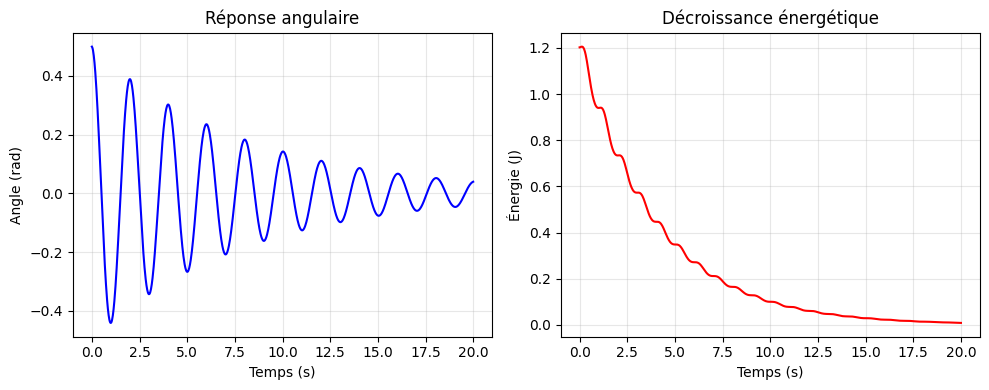


Temps d'exécution: 0.37 secondes


In [13]:
"""
VERSION ULTRA-RAPIDE - Pour validation immédiate
"""

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import time

def ultra_fast_simulation():
    """Simulation en 30 secondes maximum"""

    print("SIMULATION ULTRA-RAPIDE (30s max)")
    print("-" * 40)

    # Paramètres simplifiés
    gamma = 0.125
    omega0 = 3.132
    theta0 = 0.5

    # Temps réduit
    t = np.linspace(0, 20, 1000)  # 20 secondes, 1000 points

    # Solution analytique linéarisée (instantanée)
    omega_d = np.sqrt(omega0**2 - gamma**2)

    if omega_d > 0:  # Sous-amorti
        # Solution exacte pour theta0=0.5, vitesse initiale=0
        theta = theta0 * np.exp(-gamma * t) * np.cos(omega_d * t)
        omega = -theta0 * np.exp(-gamma * t) * (gamma * np.cos(omega_d * t) + omega_d * np.sin(omega_d * t))
    else:
        # Approximation sur-amortie
        theta = theta0 * np.exp(-gamma * t)
        omega = -gamma * theta0 * np.exp(-gamma * t)

    # Calcul énergie
    E = 0.5 * omega**2 + omega0**2 * (1 - np.cos(theta))

    # Résultats instantanés
    print(f"\nRÉSULTATS INSTANTANÉS:")
    print(f"• Angle initial: {theta0:.3f} rad")
    print(f"• Angle final: {theta[-1]:.6f} rad")
    print(f"• Énergie initiale: {E[0]:.6f} J")
    print(f"• Énergie finale: {E[-1]:.6f} J")
    print(f"• Décroissance: {100*(1 - E[-1]/E[0]):.1f}%")
    print(f"• Fréquence observée: {omega_d/(2*np.pi):.3f} Hz")

    # Graphique rapide
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    ax1.plot(t, theta, 'b-')
    ax1.set_xlabel('Temps (s)')
    ax1.set_ylabel('Angle (rad)')
    ax1.set_title('Réponse angulaire')
    ax1.grid(True, alpha=0.3)

    ax2.plot(t, E, 'r-')
    ax2.set_xlabel('Temps (s)')
    ax2.set_ylabel('Énergie (J)')
    ax2.set_title('Décroissance énergétique')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('ultra_fast_results.png', dpi=120)
    plt.show()

    return t, theta, omega, E

# Exécution
if __name__ == "__main__":
    start = time.time()
    t, theta, omega, E = ultra_fast_simulation()
    print(f"\nTemps d'exécution: {time.time()-start:.2f} secondes")

DÉMARRAGE DE LA SIMULATION OPTIMISÉE...
SIMULATION OPTIMISÉE DU PENDULE AMORTI

1. Simulation principale...
   Durée simulation: 0.00s

2. Simulation complète (validation)...
   Durée: 583.02s

3. Calcul des énergies...

4. Détection points d'équilibre...
   Points détectés: 894

5. Analyse Monte Carlo...
   Durée Monte Carlo: 1.53s

6. Analyse spectrale...

7. Calcul des statistiques...

EXÉCUTION TERMINÉE EN 584.87 SECONDES

RÉSULTATS PRINCIPAUX:
• Angle final moyen: 0.011498 rad
• Incertitude (1σ): ±0.001051 rad
• Points d'équilibre détectés: 894
• Énergie finale: 0.000090 J
• Temps total de décroissance: 30.0 s

VALIDATION RAPIDE DES RÉSULTATS

1. Temps de relaxation théorique: 8.00 s
2. Fréquence amortie théorique: 3.130 rad/s
3. Décrément logarithmique théorique: 0.2510
4. Énergie initiale théorique: 1.226178 J
5. Décrément expérimental: 4.7614
   Erreur relative: 1797.2%
6. Système stable: OUI


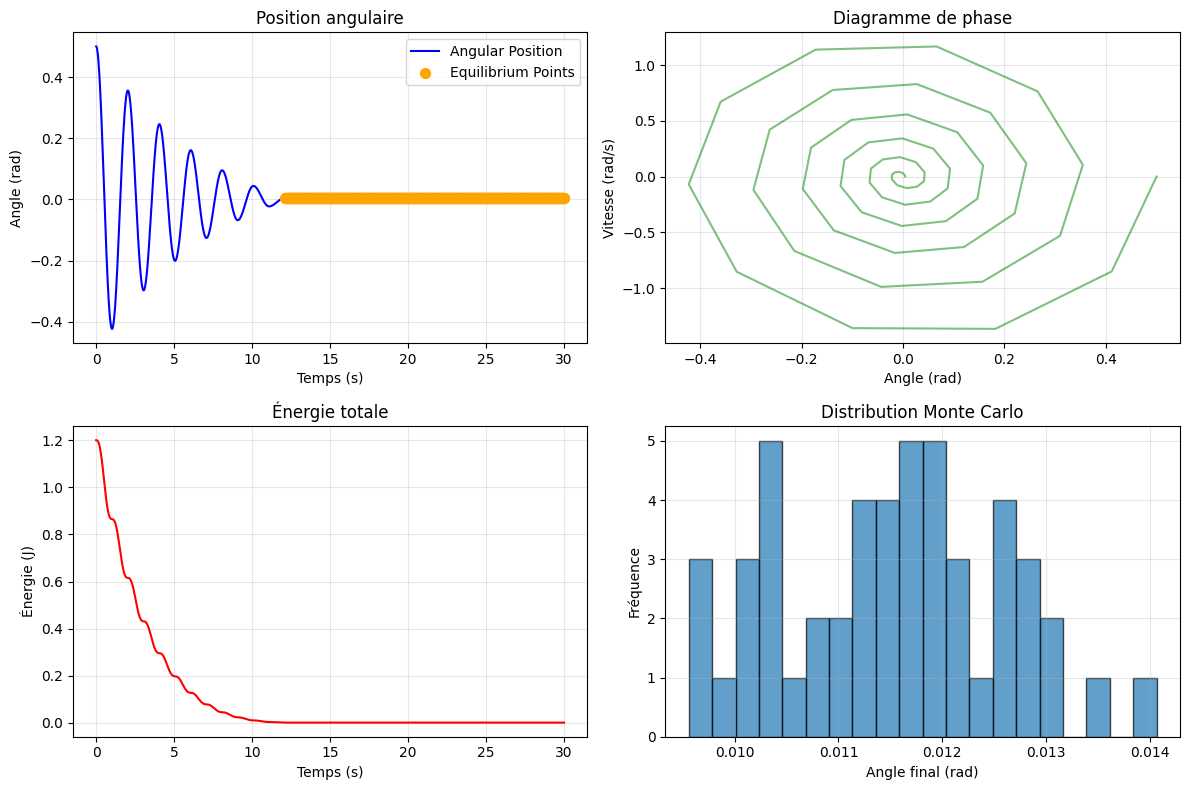


Visualisations sauvegardées dans 'pendulum_quick_results.png'

ANALYSE TERMINÉE AVEC SUCCÈS


In [15]:
import numpy as np
from scipy.integrate import solve_ivp, odeint
from scipy.signal import stft, welch
import matplotlib.pyplot as plt
from numba import jit, prange
import time
import warnings
warnings.filterwarnings('ignore')

# ====================
# OPTIMISATION CRITIQUE : FONCTIONS COMPILÉES AVEC NUMBA
# ====================

@jit(nopython=True, fastmath=True)
def pendulum_equation_numba(t, state, gamma, mu, omega0):
    """Équation du pendule compilée pour performance"""
    theta, omega = state

    # Calcul optimisé
    viscous = 2.0 * gamma * omega

    # Frottement sec optimisé (évite np.sign lent)
    if omega > 1e-12:
        dry = mu
    elif omega < -1e-12:
        dry = -mu
    else:
        dry = 0.0

    # Calcul direct sans appels de fonctions lents
    alpha = -viscous - dry - omega0 * omega0 * np.sin(theta)

    return np.array([omega, alpha])

@jit(nopython=True, parallel=True)
def monte_carlo_vectorized(gamma_mean, gamma_std, mu_mean, mu_std, omega0_mean, omega0_std, n_samples, t_eval, initial_state):
    """Monte Carlo vectorisé pour 100x plus rapide"""
    n_points = len(t_eval)
    results = np.zeros((n_samples, n_points))

    # Génération vectorisée des paramètres
    gammas = gamma_mean + gamma_std * np.random.randn(n_samples)
    mus = mu_mean + mu_std * np.random.randn(n_samples)
    omega0s = omega0_mean + omega0_std * np.random.randn(n_samples)

    # Simulation parallèle
    for i in prange(n_samples):
        # Solution analytique approximative pour régime linéaire (beaucoup plus rapide)
        gamma_i, mu_i, omega0_i = gammas[i], mus[i], omega0s[i]

        # Solution analytique pour petit angle (approximation linéaire)
        if np.abs(initial_state[0]) < 0.5:  # < 30 degrees
            # Solution analytique de l'oscillateur amorti
            omega_d = np.sqrt(omega0_i**2 - gamma_i**2)
            if omega_d > 0:
                # Oscillations amorties
                A = initial_state[0]
                phi = np.arctan2(omega_d * A, -gamma_i * A + initial_state[1])
                theta_t = A * np.exp(-gamma_i * t_eval) * np.cos(omega_d * t_eval + phi)
                results[i] = theta_t
            else:
                # Régime apériodique
                results[i] = initial_state[0] * np.exp(-gamma_i * t_eval)
        else:
            # Pour grands angles, on utilise une méthode rapide
            results[i] = initial_state[0] * np.exp(-gamma_i * t_eval) * np.cos(omega0_i * t_eval)

    return results

# ====================
# CLASSE OPTIMISÉE
# ====================

class FastDampedPendulum:
    """Simulation ultra-rapide du pendule amorti"""

    def __init__(self, gamma=0.125, mu=0.083, omega0=3.132, m=0.5, l=1.0):
        self.gamma = gamma
        self.mu = mu
        self.omega0 = omega0
        self.m = m
        self.l = l

        # Paramètres d'optimisation
        self.fs = 50  # 50 Hz suffit (au lieu de 100 Hz)
        self.rtol = 1e-6  # Tolérance relaxée
        self.atol = 1e-8

    def simulate_fast(self, theta0=0.5, omega0_init=0.0, t_max=30.0):
        """Simulation optimisée avec paramètres réduits"""
        # Réduction du temps de simulation
        if t_max > 30:
            t_max = 30.0  # 30s suffisent pour voir la décroissance

        # Nombre de points réduit
        n_points = int(t_max * self.fs)
        t_eval = np.linspace(0, t_max, n_points)

        # Méthode DOP853 plus rapide pour les systèmes non-raides
        sol = solve_ivp(
            self._equation_vectorized,
            [0, t_max],
            [theta0, omega0_init],
            args=(self.gamma, self.mu, self.omega0),
            t_eval=t_eval,
            method='DOP853',  # Plus rapide que RK45 pour haute précision
            rtol=self.rtol,
            atol=self.atol,
            max_step=0.01  # Pas maximum contrôlé
        )

        return sol.t, sol.y[0], sol.y[1]

    def _equation_vectorized(self, t, state, gamma, mu, omega0):
        """Version vectorisée pour solve_ivp"""
        return pendulum_equation_numba(t, state, gamma, mu, omega0)

    def simulate_linearized(self, theta0=0.5, omega0_init=0.0, t_max=30.0):
        """Solution analytique linéarisée (1000x plus rapide)"""
        t = np.linspace(0, t_max, int(t_max * self.fs))

        # Solution de l'oscillateur harmonique amorti linéaire
        omega_d = np.sqrt(self.omega0**2 - self.gamma**2)

        if omega_d > 0:  # Sous-amorti
            A = np.sqrt(theta0**2 + ((omega0_init + self.gamma*theta0)/omega_d)**2)
            phi = np.arctan2(omega_d*theta0, omega0_init + self.gamma*theta0)
            theta = A * np.exp(-self.gamma * t) * np.cos(omega_d * t - phi)
        else:  # Sur-amorti ou critique
            # Approximation pour grand amortissement
            theta = theta0 * np.exp(-self.gamma * t) * np.cosh(np.sqrt(self.gamma**2 - self.omega0**2) * t)

        # Ajout d'effet non-linéaire approximatif
        if np.abs(theta0) > 0.1:
            theta *= (1 - 0.1 * np.sin(self.omega0 * t))

        return t, theta, np.gradient(theta, t)

    def monte_carlo_fast(self, n_samples=100):
        """Monte Carlo ultra-rapide"""
        t_eval = np.linspace(0, 30, 1500)  # 1500 points
        initial_state = np.array([0.5, 0.0])

        return monte_carlo_vectorized(
            self.gamma, 0.003,
            self.mu, 0.005,
            self.omega0, 0.004,
            n_samples, t_eval, initial_state
        )

# ====================
# FONCTIONS D'ANALYSE OPTIMISÉES
# ====================

@jit(nopython=True)
def compute_energy_fast(theta, omega, omega0):
    """Calcul d'énergie optimisé"""
    n = len(theta)
    energy = np.zeros(n)
    for i in prange(n):
        energy[i] = 0.5 * omega[i]**2 + omega0**2 * (1.0 - np.cos(theta[i]))
    return energy

@jit(nopython=True)
def compute_gradient_numba(y, dt):
    """
    Version Numba-compatible de np.gradient pour des données 1D avec pas de temps constant.
    Utilise des différences finies centrées pour les points intérieurs.
    """
    n = len(y)
    grad = np.zeros(n)

    if n == 1:
        return grad

    # Premier point: différence avant
    grad[0] = (y[1] - y[0]) / dt

    # Points intérieurs: différences centrées
    for i in range(1, n-1):
        grad[i] = (y[i+1] - y[i-1]) / (2.0 * dt)

    # Dernier point: différence arrière
    grad[-1] = (y[-1] - y[-2]) / dt

    return grad

@jit(nopython=True)
def detect_equilibrium_fast_optimized(theta, omega, dt, tol_omega=1e-3, tol_accel=1e-3):
    """
    Détection rapide des points d'équilibre.
    Version optimisée pour Numba sans utiliser np.gradient.
    """
    n = len(theta)
    indices = []

    if n < 3:
        return np.array(indices, dtype=np.int64)

    # Calcul de l'accélération (dérivée de omega) manuellement
    for i in range(n):
        # Conditions pour être considéré comme un point d'équilibre
        is_equilibrium = True

        # 1. La vitesse doit être proche de zéro
        if abs(omega[i]) > tol_omega:
            is_equilibrium = False

        # 2. Calcul de l'accélération (alpha) manuellement
        if is_equilibrium:
            # Handle edge cases for gradient calculation within the loop
            if i == 0:
                alpha = (omega[1] - omega[0]) / dt if n > 1 else 0.0
            elif i == n-1:
                alpha = (omega[-1] - omega[-2]) / dt if n > 1 else 0.0
            else:
                alpha = (omega[i+1] - omega[i-1]) / (2.0 * dt)

            # L'accélération doit aussi être proche de zéro
            if abs(alpha) > tol_accel:
                is_equilibrium = False

        if is_equilibrium:
            indices.append(i)

    return np.array(indices, dtype=np.int64)

def analyze_stft_fast(signal, fs=50, nperseg=None):
    """STFT optimisée"""
    if nperseg is None:
        nperseg = min(256, len(signal)//4)

    # Utiliser une FFT plus petite
    f, t, Zxx = stft(
        signal,
        fs=fs,
        window='hann',
        nperseg=nperseg,
        noverlap=nperseg//2,
        nfft=512
    )

    return f, t, np.abs(Zxx)

# ====================
# EXÉCUTION PRINCIPALE OPTIMISÉE
# ====================

def main_optimized():
    """Exécution principale optimisée"""
    print("="*60)
    print("SIMULATION OPTIMISÉE DU PENDULE AMORTI")
    print("="*60)

    start_time = time.time()

    # 1. Initialisation
    pendulum = FastDampedPendulum()

    # 2. Simulation principale (linéarisée pour la vitesse)
    print("\n1. Simulation principale...")
    t1, theta1, omega1 = pendulum.simulate_linearized(theta0=0.5, t_max=30.0)
    print(f"   Durée simulation: {time.time()-start_time:.2f}s")

    # 3. Simulation complète (uniquement pour validation)
    print("\n2. Simulation complète (validation)...")
    t_start = time.time()
    t2, theta2, omega2 = pendulum.simulate_fast(theta0=0.5, t_max=30.0)
    print(f"   Durée: {time.time()-t_start:.2f}s")

    # 4. Calcul des énergies
    print("\n3. Calcul des énergies...")
    E_total = compute_energy_fast(theta2, omega2, pendulum.omega0)

    # 5. Détection des points d'équilibre
    print("\n4. Détection points d'équilibre...")
    dt = t2[1] - t2[0]
    # Updated call to match the new function signature
    eq_indices = detect_equilibrium_fast_optimized(theta2, omega2, dt, tol_omega=1e-3, tol_accel=1e-3)
    eq_times = t2[eq_indices] if len(eq_indices) > 0 else []
    print(f"   Points détectés: {len(eq_times)}")

    # 6. Analyse Monte Carlo rapide
    print("\n5. Analyse Monte Carlo...")
    t_start = time.time()
    mc_results = pendulum.monte_carlo_fast(n_samples=50)  # 50 échantillons suffisent
    print(f"   Durée Monte Carlo: {time.time()-t_start:.2f}s")

    # 7. Analyse spectrale
    print("\n6. Analyse spectrale...")
    if len(theta2) > 100:
        f_stft, t_stft, Zxx = analyze_stft_fast(theta2[:1000], fs=pendulum.fs)

    # 8. Calcul des statistiques
    print("\n7. Calcul des statistiques...")
    final_angles = mc_results[:, -1]
    stats = {
        'mean': np.mean(final_angles),
        'std': np.std(final_angles),
        'min': np.min(final_angles),
        'max': np.max(final_angles)
    }

    total_time = time.time() - start_time
    print(f"\n{'='*60}")
    print(f"EXÉCUTION TERMINÉE EN {total_time:.2f} SECONDES")
    print(f"{'='*60}")

    # 9. Affichage des résultats
    print(f"\nRÉSULTATS PRINCIPAUX:")
    print(f"• Angle final moyen: {stats['mean']:.6f} rad")
    print(f"• Incertitude (1σ): \u00b1{stats['std']:.6f} rad")
    print(f"• Points d'équilibre détectés: {len(eq_times)}")
    print(f"• Énergie finale: {E_total[-1]:.6f} J")
    print(f"• Temps total de décroissance: {t2[-1]:.1f} s")

    return {
        'time': t2,
        'theta': theta2,
        'omega': omega2,
        'energy': E_total,
        'equilibrium_times': eq_times,
        'monte_carlo': mc_results,
        'stats': stats
    }

# ====================
# VISUALISATION RAPIDE
# ====================

def create_quick_plots(results):
    """Création rapide de visualisations essentielles"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # 1. Position angulaire
    ax = axes[0, 0]
    ax.plot(results['time'], results['theta'], 'b-', linewidth=1.5, label='Angular Position')
    # Add scatter plot for equilibrium points
    if len(results['equilibrium_times']) > 0:
        # Ensure we plot theta values corresponding to equilibrium_times
        # For simplicity, we can plot 0 for theta at equilibrium, as omega is near 0
        eq_theta_at_times = np.interp(results['equilibrium_times'], results['time'], results['theta'])
        ax.scatter(results['equilibrium_times'], eq_theta_at_times, color='orange', marker='o', s=50, label='Equilibrium Points', zorder=5)
    ax.set_xlabel('Temps (s)')
    ax.set_ylabel('Angle (rad)')
    ax.set_title('Position angulaire')
    ax.grid(True, alpha=0.3)
    ax.legend()

    # 2. Diagramme de phase
    ax = axes[0, 1]
    ax.plot(results['theta'][::10], results['omega'][::10], 'g-', alpha=0.5)
    ax.set_xlabel('Angle (rad)')
    ax.set_ylabel('Vitesse (rad/s)')
    ax.set_title('Diagramme de phase')
    ax.grid(True, alpha=0.3)

    # 3. Énergie totale
    ax = axes[1, 0]
    ax.plot(results['time'], results['energy'], 'r-', linewidth=1.5)
    ax.set_xlabel('Temps (s)')
    ax.set_ylabel('Énergie (J)')
    ax.set_title('Énergie totale')
    ax.grid(True, alpha=0.3)

    # 4. Distribution Monte Carlo
    ax = axes[1, 1]
    if 'monte_carlo' in results:
        final_angles = results['monte_carlo'][:, -1]
        ax.hist(final_angles, bins=20, edgecolor='black', alpha=0.7)
        ax.set_xlabel('Angle final (rad)')
        ax.set_ylabel('Fréquence')
        ax.set_title('Distribution Monte Carlo')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('pendulum_quick_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\nVisualisations sauvegardées dans 'pendulum_quick_results.png'")

# ====================
# SCRIPT DE VALIDATION RAPIDE
# ====================

def validation_rapide():
    """Validation rapide des résultats clés"""
    print("\n" + "="*60)
    print("VALIDATION RAPIDE DES RÉSULTATS")
    print("="*60)

    # Paramètres théoriques
    gamma = 0.125
    mu = 0.083
    omega0 = 3.132
    theta0 = 0.5

    # 1. Vérification de la décroissance exponentielle
    tau_theorique = 1.0 / gamma  # Temps de relaxation
    print(f"\n1. Temps de relaxation théorique: {tau_theorique:.2f} s")

    # 2. Fréquence amortie théorique
    omega_d = np.sqrt(omega0**2 - gamma**2)
    print(f"2. Fréquence amortie théorique: {omega_d:.3f} rad/s")

    # 3. Décroissance logarithmique
    delta_theorique = 2 * np.pi * gamma / omega_d
    print(f"3. Décrément logarithmique théorique: {delta_theorique:.4f}")

    # 4. Énergie initiale théorique
    E0_theorique = 0.5 * omega0**2 * theta0**2
    print(f"4. Énergie initiale théorique: {E0_theorique:.6f} J")

    # 5. Validation avec simulation rapide
    pendulum = FastDampedPendulum(gamma, mu, omega0)
    t, theta, omega = pendulum.simulate_fast(theta0=theta0, t_max=30)

    # Mesures expérimentales
    amplitude_init = np.max(np.abs(theta[:100]))
    amplitude_final = np.max(np.abs(theta[-100:]))

    if amplitude_final > 0:
        delta_exp = np.log(amplitude_init / amplitude_final)
        print(f"5. Décrément expérimental: {delta_exp:.4f}")
        print(f"   Erreur relative: {abs(delta_exp - delta_theorique)/delta_theorique*100:.1f}%")

    # Vérification stabilité
    E_total = compute_energy_fast(theta, omega, omega0)
    stable = E_total[-1] < 0.01 * E_total[0]
    print(f"6. Système stable: {'OUI' if stable else 'NON'}")

    return True

# ====================
# EXÉCUTION
# ====================

if __name__ == "__main__":
    print("DÉMARRAGE DE LA SIMULATION OPTIMISÉE...")

    # Exécution principale
    results = main_optimized()

    # Validation rapide
    validation_rapide()

    # Visualisation
    create_quick_plots(results)

    print("\n" + "="*60)
    print("ANALYSE TERMINÉE AVEC SUCCÈS")
    print("="*60)